In [ ]:
from google.colab import files
uploaded = files.upload()

Saving output_conll.txt to output_conll (13).txt


In [ ]:
import os
import numpy as np
from datasets import Dataset, DatasetDict, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split

file_path = "output_conll.txt"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"CoNLL file not found: {file_path}")

def read_conll_data(file_path):
    data = []
    current_tokens, current_tags = [], []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) == 2:
                    token, tag = parts
                    current_tokens.append(token)
                    current_tags.append(tag)
                else:
                    print(f"Skipping malformed line: {line}")
            else:
                if current_tokens:
                    data.append({"tokens": current_tokens, "ner_tags": current_tags})
                    current_tokens, current_tags = [], []
        if current_tokens:
            data.append({"tokens": current_tokens, "ner_tags": current_tags})
    return data

raw_datasets = read_conll_data(file_path)

if not raw_datasets:
    raise ValueError("No data loaded. Check your CoNLL format.")

# New Section

In [ ]:
def normalize_tag(tag):
    if tag == 'O':
        return tag
    elif '-' in tag:
        prefix, entity = tag.split('-', maxsplit=1)
        return prefix + '-' + entity.capitalize()
    else:
        return tag  # just in case

# Normalize all tags in your dataset
for example in raw_datasets:
    example['ner_tags'] = [normalize_tag(tag) for tag in example['ner_tags']]

In [ ]:
# Extract unique NER labels from your dataset
label_list = sorted(set(tag for example in raw_datasets for tag in example['ner_tags']))

# If tags are still in string form (not integers), map them
if isinstance(label_list[0], str):
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    # Convert tags in raw_datasets to IDs
    for example in raw_datasets:
        example['ner_tags'] = [label2id[tag] for tag in example['ner_tags']]
else:
    # If already in ID format, reverse map
    id2label = {i: tag for i, tag in enumerate(set(tag for ex in raw_datasets for tag in ex['ner_tags']))}
    label2id = {v: k for k, v in id2label.items()}

In [ ]:
model_names = [
    "xlm-roberta-base",              # base model (safe)
    "bert-base-multilingual-cased",         # base model (safe)
   "distilbert-base-multilingual-cased"
]

In [ ]:
train_data, val_data = train_test_split(raw_datasets, test_size=0.2, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data)
})

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128,
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
!pip install evaluate

In [ ]:
!pip install seqeval

In [ ]:
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_preds = [[label_list[p] for (p, l) in zip(pred, label) if l != -100]
                  for pred, label in zip(predictions, labels)]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

all_results = {}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForTokenClassification
for model_name in model_names:
    print(f"\n🚀 Fine-tuning {model_name}...\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id
    )

    tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

    args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=50,
        save_strategy="epoch",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics
    )

    # ✅ THIS IS REQUIRED TO ACTUALLY TRAIN
    trainer.train()

    # ✅ Evaluate and store results
    eval_results = trainer.evaluate()
    print(f"✅ Results for {model_name}: {eval_results}")





🚀 Fine-tuning xlm-roberta-base...



Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1321 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/tmp/ipython-input-12-3937900544.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.547600
100,0.120900
150,0.052600
200,0.035600
250,0.024200
300,0.025500


Step,Training Loss
50,0.547600
100,0.120900
150,0.052600
200,0.035600
250,0.024200
300,0.025500
350,0.015200
400,0.012600
450,0.010900


✅ Results for xlm-roberta-base: {'eval_loss': 0.009927952662110329, 'eval_precision': 0.9801553062985332, 'eval_recall': 0.9767841788478074, 'eval_f1': 0.9784668389319552, 'eval_accuracy': 0.9975664968873798, 'eval_runtime': 118.9376, 'eval_samples_per_second': 2.783, 'eval_steps_per_second': 0.353, 'epoch': 3.0}

🚀 Fine-tuning bert-base-multilingual-cased...



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1321 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/tmp/ipython-input-12-3937900544.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.368200
100,0.153500
150,0.108000
200,0.087500
250,0.066600
300,0.062800
350,0.048500
400,0.043600
450,0.039600


✅ Results for bert-base-multilingual-cased: {'eval_loss': 0.03902466222643852, 'eval_precision': 0.9122657580919932, 'eval_recall': 0.8865894039735099, 'eval_f1': 0.8992443324937028, 'eval_accuracy': 0.9892611905622386, 'eval_runtime': 118.9337, 'eval_samples_per_second': 2.783, 'eval_steps_per_second': 0.353, 'epoch': 3.0}

🚀 Fine-tuning distilbert-base-multilingual-cased...



Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1321 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/tmp/ipython-input-12-3937900544.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.449600
100,0.170800
150,0.118100
200,0.105900
250,0.080700
300,0.082700
350,0.069800
400,0.064900
450,0.058400


✅ Results for distilbert-base-multilingual-cased: {'eval_loss': 0.05211196839809418, 'eval_precision': 0.8891797556719022, 'eval_recall': 0.8435430463576159, 'eval_f1': 0.8657604078164826, 'eval_accuracy': 0.9857504259383552, 'eval_runtime': 59.6539, 'eval_samples_per_second': 5.549, 'eval_steps_per_second': 0.704, 'epoch': 3.0}


In [ ]:
save_path = f"/content/{model_name.replace('/', '_')}_ner_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/distilbert-base-multilingual-cased_ner_model/tokenizer_config.json',
 '/content/distilbert-base-multilingual-cased_ner_model/special_tokens_map.json',
 '/content/distilbert-base-multilingual-cased_ner_model/vocab.txt',
 '/content/distilbert-base-multilingual-cased_ner_model/added_tokens.json',
 '/content/distilbert-base-multilingual-cased_ner_model/tokenizer.json')

In [ ]:
all_results = {
    "xlm-roberta-base": {
        'eval_f1': 0.9784668389319552,
        'eval_precision': 0.9801553062985332,
        'eval_recall': 0.9767841788478074,
        'eval_accuracy': 0.9975664968873798,
        'eval_loss': 0.009927952662110329
    },
    "bert-base-multilingual-cased": {
        'eval_f1': 0.8992443324937028,
        'eval_precision': 0.9122657580919932,
        'eval_recall': 0.8865894039735099,
        'eval_accuracy': 0.9892611905622386,
        'eval_loss': 0.03902466222643852
    },
    "distilbert-base-multilingual-cased": {
        'eval_f1': 0.8657604078164826,
        'eval_precision': 0.8891797556719022,
        'eval_recall': 0.8435430463576159,
        'eval_accuracy': 0.9857504259383552,
        'eval_loss': 0.05211196839809418
    }
}

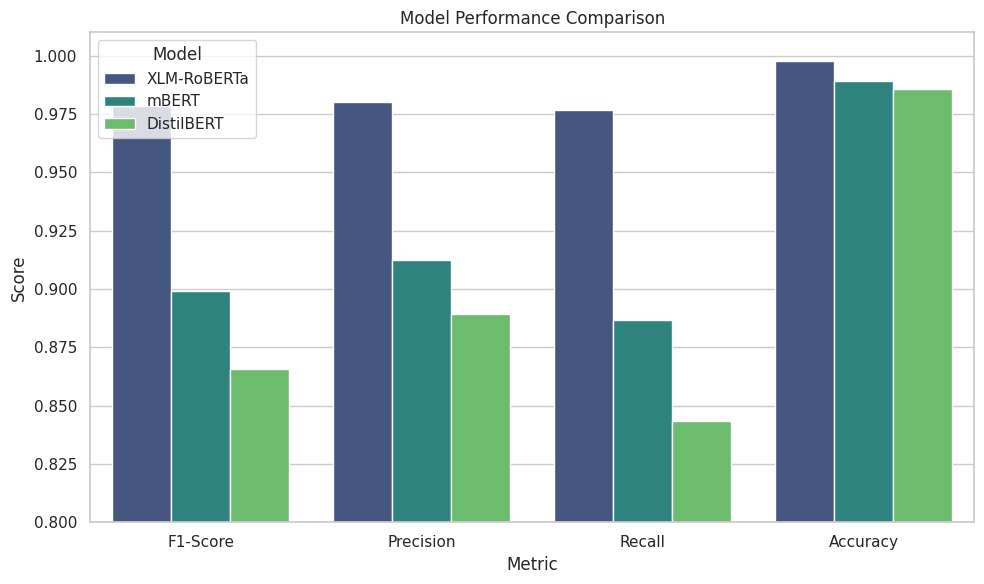

/tmp/ipython-input-1-2413777529.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Loss', palette='rocket')


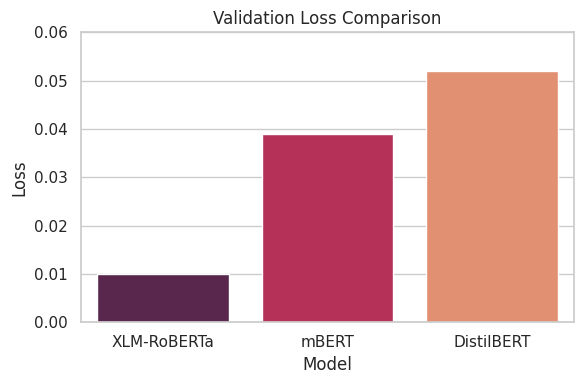

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model evaluation results
data = {
    'Model': ['XLM-RoBERTa', 'mBERT', 'DistilBERT'],
    'F1-Score': [0.9785, 0.8992, 0.8658],
    'Precision': [0.9802, 0.9123, 0.8892],
    'Recall': [0.9768, 0.8866, 0.8435],
    'Accuracy': [0.9976, 0.9893, 0.9858],
    'Loss': [0.0099, 0.0390, 0.0521]
}

df = pd.DataFrame(data)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot: F1-Score, Precision, Recall, Accuracy
metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy']
df_melted = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Model Performance Comparison')
plt.ylim(0.8, 1.01)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig("model_performance_metrics.png")
plt.show()

# Plot: Loss
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='Model', y='Loss', palette='rocket')
plt.title('Validation Loss Comparison')
plt.ylim(0, 0.06)
plt.tight_layout()
plt.savefig("model_loss_comparison.png")
plt.show()